# Main

## Librerias a utilizar

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import time
import sys
import hashlib


## Importando CSV

In [2]:
df_names = pd.read_table('Popular-Baby-Names-Final.csv', dtype={"Name": "string"})

In [3]:
df_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93889 entries, 0 to 93888
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    93888 non-null  string
dtypes: string(1)
memory usage: 733.6 KB


In [4]:
array_names = df_names.dropna().Name.to_numpy()
array_names.astype(str, copy=False)
del df_names

In [5]:
sys.getsizeof(array_names)

751216

In [6]:
df_movie = pd.read_csv("Film-Names.csv", skiprows=1,names=["Name"], dtype={"Name": "string"})

In [7]:
df_movie = df_movie.replace(";","", regex=True)

In [8]:
array_movies = df_movie.dropna().Name.to_numpy()
array_movies.astype(str, copy=False)
del df_movie

In [9]:
sys.getsizeof(array_movies)

30576

## Creando el Filtro Bloom

In [10]:
# Función que crea un arreglo con funciones de hashing, se usa como muestra el siguiente ejemplo
def create_hash_functions(k, m):
    hash_functions = []
    for i in range(k):
        def hash_function(value):
            hash_object = hashlib.sha256(str(i).encode('utf-8'))
            hash_object.update(str(value).encode('utf-8'))
            hash_value = int(hash_object.hexdigest(), 16)
            return hash_value % m
        hash_functions.append(hash_function)
    return hash_functions

#----------------------------------------
# Ejemplo de prueba:

# Se crea un arreglo con k=3 funciones hashing y largo del arreglo m=10 bits
hash_functions = create_hash_functions(3, 10)

# Conjunto de elementos de prueba
values = ["ola", "perro", "123", "xd", "aaaaaaaaaaaaaaaaahhhh"]

# Por cada elemento en values, calculo el hashing (es decir la posición en M) por cada función de hashing (en nuestro caso las funciones son k=3)
for value in values:
    hash_values = [hash_function(value) for hash_function in hash_functions]
    print(f"Value {value}: {hash_values}")

#----------------------------------------

#Intento 2 de la creación de las funciones de hashing:
def hash_generator(m):
    i = 0
    while True:
        # Define una función hash que toma un valor como entrada y devuelve un valor hash
        def hash_function(value):
            nonlocal i
            # Crea un objeto hash utilizando SHA-256 y la semilla i
            hash_object = hashlib.sha256(str(i).encode('utf-8'))
            # Actualiza el objeto hash con el valor de entrada
            hash_object.update(str(value).encode('utf-8'))
            # Obtiene el valor hash y lo convierte en un número entero
            hash_value = int(hash_object.hexdigest(), 16)
            # Incrementa la semilla i
            i += 1
            # Devuelve el valor hash módulo m
            return hash_value % m
        # Devuelve la función hash creada
        yield hash_function

# create a hash generator with range m (length of M)
m=10
hash_gen = hash_generator(10)

# generate k=3 hash functions
k = 3
hash_functions = [next(hash_gen) for _ in range(k)]

# apply each value to each hash function
values = ["ola", "perro", "123", "xd", "aaaaaaaaaaaaaaaaahhhh"]
for value in values:
    hash_values = [hash_function(value) for hash_function in hash_functions]
    print(f"Value {value}: {hash_values}")


Value ola: [5, 5, 5]
Value perro: [9, 9, 9]
Value 123: [8, 8, 8]
Value xd: [9, 9, 9]
Value aaaaaaaaaaaaaaaaahhhh: [2, 2, 2]
Value ola: [4, 7, 5]
Value perro: [1, 5, 8]
Value 123: [2, 3, 9]
Value xd: [6, 9, 2]
Value aaaaaaaaaaaaaaaaahhhh: [8, 4, 3]


## Creando búsquedas

In [11]:
class SearchBloomExp:
    
    def __init__(self, database: np.ndarray[str], num_funct_hash: int, size_array_M: int) -> None:
        self.arrayM = np.zeros(size_array_M, dtype=int)
        hash_gen = hash_generator(size_array_M)
        self.listFuncHash = [next(hash_gen) for _ in range(num_funct_hash)]
        self.db = database.copy()
        # train function hash
        for x in self.db:
            list_index = [f_hash(x) for f_hash in self.listFuncHash]
            for y in list_index:
                self.arrayM[y] = 1
            
        
    def busqueda_sin_filtro(self, texto: str) -> bool:
        for name in self.db:
            if (name == texto):
                return True
        return False
    
    def filtro_bloom(self, texto: str) -> bool:
        # Obtenemos
        list_index = [f_hash(texto) for f_hash in self.listFuncHash]
        return bool(np.array([self.arrayM[y] for y in list_index]).prod())

## Experimentos

In [117]:
word_search = []
value_filter = []
value_search = []
time_filter = []
time_search = []
num_funct_hash = []
size_array = []

# Condiciones del experimento
k_max = 100
M_max = 100
seed = 1234
rng = np.random.default_rng(seed=seed)
database = array_names
data_false = array_movies
size_test = 100

for k in range(3,k_max+1):
    for M in range(3,M_max+1):
        # Creamos un objeto que nos ayudara con los procesos internos
        test = SearchBloomExp(database=database,num_funct_hash=k+1,size_array_M=M+1)
        # Partiremos haciendo que busque elementos
        # que sabemos que estan en la base de datos
        # analizando los resultados del filtro como 
        # de buscar directamente en la base de datos
        
        sample_database = rng.choice(database, size=size_test,replace=False).astype(str,copy=False)
        
        word_search += [txt for txt in sample_database]
        num_funct_hash += [k for _ in sample_database]   
        size_array += [M for _ in sample_database]
        
        for name in sample_database:
            # Busqueda en el filtro   
            init_time = time.perf_counter_ns()
            res = test.filtro_bloom(name)
            time_filter.append(time.perf_counter_ns()-init_time)
            value_filter.append(res)
            # Busqueda en la DB
            init_time = time.perf_counter_ns()
            res = test.busqueda_sin_filtro(name)
            time_search.append(time.perf_counter_ns()-init_time)
            value_search.append(res)

        sample_data_false = rng.choice(data_false, size=size_test,replace=False).astype(str,copy=False)
        # Ahora analizamos los tiempos de las busquedas infrutiferas
        word_search += [txt for txt in sample_data_false]
        num_funct_hash += [k for _ in sample_data_false]   
        size_array += [M for _ in sample_data_false]
        for name in sample_data_false:
            # Busqueda en el filtro   
            init_time = time.perf_counter_ns()
            res = test.filtro_bloom(name)
            time_filter.append(time.perf_counter_ns()-init_time)
            value_filter.append(res)
            # Busqueda en la DB
            init_time = time.perf_counter_ns()
            res = test.busqueda_sin_filtro(name)
            time_search.append(time.perf_counter_ns()-init_time)
            value_search.append(res)
        
        # Liberamos memoria y dejamos la variable test limpia
        del test

dict_data = {"WordSearch":word_search,
             "ValueFilter":value_filter,
             "ValueSearch":value_search,
             "TimeFilter":time_filter,
             "TimeSearch":time_search,
             "NumFunctHash": num_funct_hash,
             "SizeArray": size_array,
             }

df = pd.DataFrame(dict_data)

df.to_csv("resultados.txt", index=False)

# Gráficos

In [120]:
dataset = pd.read_csv("resultados.txt", dtype={"WordSearch":"string",
                                               "ValueFilter":bool,
                                               "ValueSearch":bool,
                                               "TimeFilter":int,
                                               "TimeSearch":int,
                                               "NumFunctHash": int,
                                               "SizeArray": int,
                                               },
                      )
dataset

,WordSearch,ValueFilter,ValueSearch,TimeFilter,TimeSearch,NumFunctHash,SizeArray
0,CLARINCE,True,True,23700,259700,3,3
1,CHAZZ,True,True,9200,652800,3,3
2,SHENIQUE,True,True,18600,494800,3,3
3,MARIYANI,True,True,12600,1385200,3,3
4,PLAS,True,True,17900,243800,3,3
...,...,...,...,...,...,...,...
1920795,BOOGIE,True,False,220700,2610500,100,100
1920796,IMPRACTICAL JOKERS,True,False,234700,2275700,100,100
1920797,CLASSICAL BABY,True,False,254700,2414500,100,100
1920798,OLIVER TWIST,True,False,241700,2367000,100,100


In [121]:
dataset.dropna(inplace=True)
dataset.reset_index(drop=True,inplace=True)

In [122]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920546 entries, 0 to 1920545
Data columns (total 7 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   WordSearch    string
 1   ValueFilter   bool  
 2   ValueSearch   bool  
 3   TimeFilter    int32 
 4   TimeSearch    int32 
 5   NumFunctHash  int32 
 6   SizeArray     int32 
dtypes: bool(2), int32(4), string(1)
memory usage: 47.6 MB


In [123]:
dataset.shape[0]

1920546

In [124]:
dataset["RealTimeSearch"] = [(dataset.loc[i,"TimeFilter"] + dataset.loc[i,"TimeSearch"] if not dataset.loc[i,"ValueFilter"] else dataset.loc[i,"TimeFilter"]) for i in range(dataset.shape[0])]

In [125]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920546 entries, 0 to 1920545
Data columns (total 8 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   WordSearch      string
 1   ValueFilter     bool  
 2   ValueSearch     bool  
 3   TimeFilter      int32 
 4   TimeSearch      int32 
 5   NumFunctHash    int32 
 6   SizeArray       int32 
 7   RealTimeSearch  int32 
dtypes: bool(2), int32(5), string(1)
memory usage: 54.9 MB


<Axes: xlabel='SizeArray', ylabel='RealTimeSearch'>

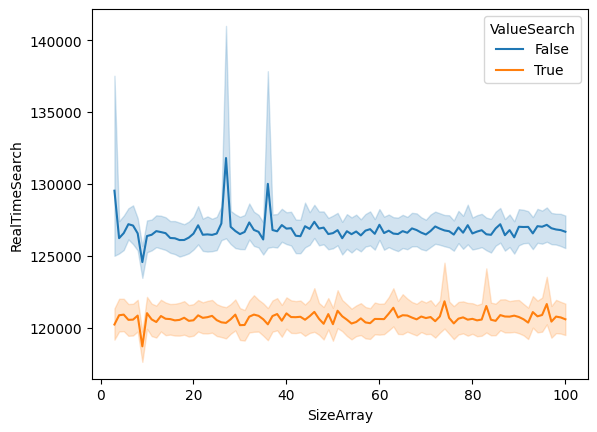

In [128]:
sns.lineplot(dataset,
             y="RealTimeSearch",
             x="SizeArray",
             hue="ValueSearch",
             estimator="mean",
             )

<Axes: xlabel='NumFunctHash', ylabel='RealTimeSearch'>

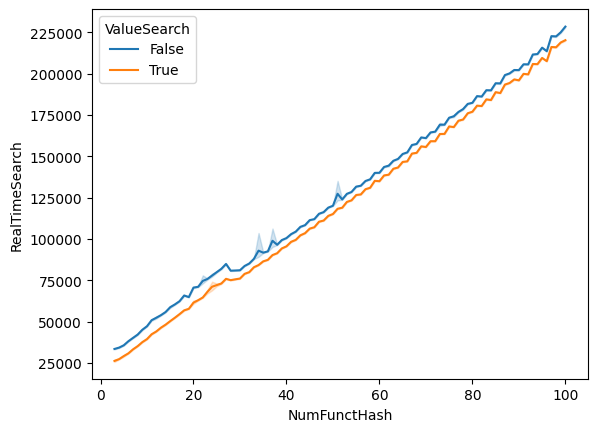

In [129]:
sns.lineplot(dataset,
             y="RealTimeSearch",
             x="NumFunctHash",
             hue="ValueSearch",
             estimator="mean",
             )

In [130]:
dataset["NumFunctHash"].unique()

array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100])

In [131]:
dataset["SizeArray"].unique()

array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100])

<Axes: >

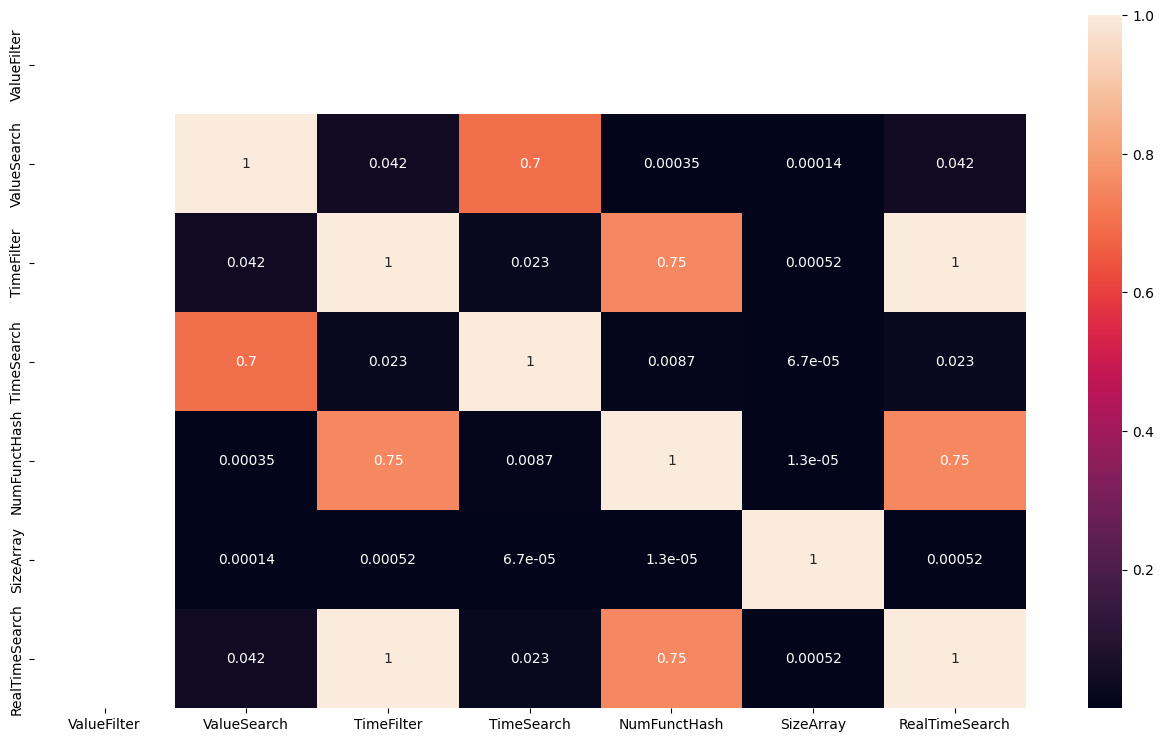

In [144]:
fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(abs(dataset.corr(numeric_only=True)),
            annot=True,
            ax=ax)

In [132]:
dataset["SizeArray"].unique().merge( right=dataset["NumFunctHash"].unique(), how="cross")

AttributeError: 'numpy.ndarray' object has no attribute 'merge'